In [1]:
import os
import scanpy as sc
import numpy as np
import multiprocessing
import anndata
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from scipy import sparse
from scipy.stats import norm


/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
batchid_string="barcode"
positiveQuantile=0.99
n_clust=None
n_init=100
kfunc="kmeans"
maxneighbor=100
seed=33
keep_input=True
verbose=True

In [3]:
path = '/Users/antonogorodnikov/Documents/Work/DataSci/SCITO-seq/tests/100k_pbmc_filtered_feature_bc_matrix.h5'
verbose = True

In [4]:
adata = sc.read_10x_h5(path, gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
corr_var = pd.read_csv("/Users/antonogorodnikov/Documents/Work/DataSci/SCITO-seq/tests/var.csv", index_col=0)

In [6]:
adata.var = corr_var

In [7]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
TCR_Va24-Ja18_barcode10,Ab10TCR_Va24-Ja18,Antibody Capture,NaN
CD38_barcode10,Ab10CD38,Antibody Capture,NaN
HLA_DR_barcode10,Ab10HLA_DR,Antibody Capture,NaN
PD-1_barcode10,Ab10PD-1,Antibody Capture,NaN


In [9]:
def count_collapser(data, bc):
    '''
    Collapses counts for all antibodies for a given batch barcode. Outputs dense data structure
    :param data: sparse or dense data (AnnData or DataFrame) with counts
    :param bc: batch barcode
    :return: .collapsed = Numpy array of cells by batch BC.
            .n_ab = number of antibodies per batch (quality check)
    '''
    # TODO add handle for dense data
    rel_data = data[:,data.var.index.str.contains(r'(%s$)'%bc)]

    # collapse counts
    collapsed = rel_data.X.toarray().sum(axis=1).astype("int")

    return collapsed


In [10]:
batches = adata.var_names.str.extract(r'(%s\d+)'%batchid_string).iloc[:,0].dropna().unique()
nClust = n_clust if n_clust != None else len(batches)+1

# extract only antibody counts
ab_adata = adata[:,adata.var_names.str.contains(r'(%s\d+)'%batchid_string)]

# test that every batch has same number of anitbodies

# TODO: try to catch this exception and look for other identifiers
num_ab = set([ab_adata[:, ab_adata.var_names.str.contains(r'(%s$)' % x)].n_vars for x in batches])
assert(len(num_ab) == 1), "ERROR: different number of antibodies per batch. Program exit"



# collapse counts within batch
batch_counts = np.transpose(np.array([count_collapser(ab_adata, bc) for bc in batches]))

# create anndata object with collapsed counts per batch
batch_adata = anndata.AnnData(X=sparse.csr_matrix(batch_counts),
                              obs=adata.obs,
                              var=pd.DataFrame(batches, columns=['batch']))
batch_counts = None


Transforming to str index.


In [11]:
sc.pp.normalize_per_cell(batch_adata, counts_per_cell_after=1e4)
if verbose:
    print("Keeping linear scale data for computing average")
batch_adataNormLin = batch_adata.copy()
sc.pp.log1p(batch_adata)

Keeping linear scale data for computing average


In [12]:
np.transpose(batch_adata.X.todense())[:10,:10]

matrix([[4.7559476, 5.066585 , 5.8709655, 5.9274697, 5.9704304,
         5.9913907, 4.7215414, 5.6070642, 6.341015 , 6.181942 ],
        [7.673621 , 4.2514076, 5.772817 , 5.604701 , 5.9377255,
         5.1509776, 7.5158   , 5.420608 , 5.76702  , 5.6493173],
        [8.851336 , 5.5250697, 6.608448 , 6.203811 , 5.9377255,
         8.995971 , 8.919161 , 9.015218 , 5.9895377, 5.7601724],
        [4.4029517, 7.685743 , 5.5418267, 5.715539 , 5.694258 ,
         5.268117 , 4.4291325, 4.607887 , 5.76702  , 5.4559155],
        [5.238142 , 4.61474  , 5.6248946, 5.411333 , 8.393474 ,
         5.046261 , 4.489055 , 4.9877005, 6.0329165, 5.8359275],
        [4.73085  , 8.463294 , 8.817651 , 5.9274697, 7.9346676,
         5.352854 , 4.788402 , 5.390889 , 8.80591  , 6.0338526],
        [4.915934 , 4.61474  , 5.3515964, 5.8153086, 5.9542117,
         5.4309683, 4.4291325, 5.296035 , 5.872068 , 8.897214 ],
        [4.4376206, 4.535522 , 5.6639767, 5.604701 , 5.903915 ,
         5.352854 , 4.2242413, 5.

In [13]:
clust_model = KMeans(n_clusters=nClust, n_init=n_init, random_state=seed, n_jobs=int(multiprocessing.cpu_count()*0.6))
clusters = clust_model.fit_predict(batch_adata.X.todense())

In [14]:
clusters

array([5, 7, 7, ..., 2, 1, 3], dtype=int32)

In [15]:
def av_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='batch_cluster'):
    """ Copied from https://github.com/theislab/scanpy/issues/181 - posted by one of scanpy developers
    A function go get mean expressions of feature per cluster (class).
    Data should be normalized to reads per cell, but kept in the linear scale
    #
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'batch_cluster' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = set(anndata.obs[partition_key])
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene)  # Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                anndata.obs[ens_idx[0]] = anndata.X[:, ens_idx].mean(1)  # works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = anndata.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i += 1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return (marker_exp)

In [16]:
batch_adataNormLin.obs['batch_cluster'] = clusters
batch_adata.obs['batch_cluster'] = clusters
marker_dict = {batch_adataNormLin.var.keys()[0]: batch_adataNormLin.var['batch']} # for average expression of batch oligo

av_batch_expr = av_gene_expression(batch_adataNormLin, marker_dict, gene_symbol_key='batch', partition_key='batch_cluster').iloc[:,:-1]


In [17]:
av_batch_expr

,0,1,2,3,4,5,6,7,8,9,10
barcode1,533.941528,7338.555176,606.273621,790.354553,659.250488,615.607117,698.095886,569.764099,648.659851,650.480286,582.763733
barcode2,361.844299,251.803574,358.733368,558.682739,351.738739,350.502686,446.010895,353.380951,368.188812,6574.243164,323.363525
barcode3,4274.419922,293.888489,405.886444,259.111420,510.716003,6928.638184,543.394165,403.356354,437.922577,394.863892,387.580261
barcode4,321.688110,283.239563,308.950439,440.438477,374.315735,313.613922,439.894836,347.178345,6180.692383,357.045624,357.991089
barcode5,235.548065,397.577026,443.025879,455.678802,417.298706,352.318848,5652.455078,407.633667,506.638641,372.049744,500.393005
barcode6,386.752167,375.428925,417.819489,533.722046,450.803040,401.261169,591.285095,6659.786133,493.565674,429.726990,465.965942
barcode7,368.057800,336.467987,6652.825684,502.215271,424.413391,368.879456,530.675293,426.578644,476.327087,393.390076,474.894745
barcode8,341.637726,231.882370,286.682129,490.623657,6277.550781,238.897629,404.940277,285.754822,312.614624,311.350922,312.053925
barcode9,316.118652,361.931030,353.115265,452.449432,377.933533,344.552887,461.478699,375.865051,405.404205,375.818634,6424.080078
barcode10,2859.992188,129.226089,166.688217,5516.723633,155.979279,85.728188,231.769592,170.702133,169.985550,141.030701,170.914124


In [18]:
discrete = anndata.AnnData(X=sparse.csr_matrix(np.zeros(batch_adata.shape)),
                                   obs=adata.obs,
                                   var=pd.DataFrame(batches, columns=['batch']))

Transforming to str index.


In [19]:
result = anndata.AnnData(X=sparse.csr_matrix(np.zeros((1,28))),
                      var=pd.DataFrame(index=set([x[0] for x in ab_adata.var_names.str.split(pat=batchid_string)])),
                      obs=None)

In [20]:
result

AnnData object with n_obs × n_vars = 1 × 28 

In [21]:
positiveQuantile=0.99

In [22]:
for batch_name in av_batch_expr.index:
    values = batch_adata[:, batch_adata.var['batch'] == batch_name]
    values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name, :])]
    fitty = norm.fit(values_use.X.toarray())
    cutoff = np.quantile(norm.rvs(loc=fitty[0], scale=fitty[1], size=1000, random_state=seed),
                         q=positiveQuantile)

    ox = [x[0] for x in np.argwhere(values.X > cutoff)]
    res = ab_adata[ox, ab_adata.var_names.str.contains(r'(%s$)' % batch_name)]
    res.var_names = [x[0] for x in res.var_names.str.split(pat=batchid_string)]
    res.var.drop(res.var.columns, axis=1, inplace=True)

    result = result.concatenate(res, join='outer', index_unique=None)


    discrete.X[ox, int(values.var.index[0])] = 1
    if verbose:
        print("Cutoff for {}: {} reads".format(batch_name,
                                               int(np.expm1(cutoff))))

/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Cutoff for barcode1: 2127 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode2: 731 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode3: 680 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode4: 909 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode5: 810 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode6: 1228 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode7: 1048 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode8: 661 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode9: 1100 reads


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Cutoff for barcode10: 231 reads


In [23]:
result

AnnData object with n_obs × n_vars = 58557 × 28 
    obs: 'batch'

In [33]:
set([ab_adata[:,ab_adata.var_names.str.contains(r'(%s$)'%x)].n_vars for x in batches])

{27, 28, 29}

In [174]:
batch_name = 'barcode2'
values = batch_adata[:, batch_adata.var['batch'] == batch_name]
values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name, :])]
fitty = norm.fit(values_use.X.toarray())
cutoff = np.quantile(norm.rvs(loc=fitty[0], scale=fitty[1], size=1000, random_state=seed),
                     q=positiveQuantile)

ox = [x[0] for x in np.argwhere(values.X > cutoff)]
res = ab_adata[ox,ab_adata.var_names.str.contains(r'(%s$)'%batch_name)]
res.var_names = [x[0] for x in res.var_names.str.split(pat=batchid_string)]
res.var.drop(res.var.columns,axis=1,inplace=True)

result = result.concatenate(res, join='outer', index_unique=None)

/Users/antonogorodnikov/anaconda3/envs/test2/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.


In [26]:
def drop_assigner(x):
    '''
    Assigns droplet to be empty ("NEG"), singlet ("SNG") or multiplet ("MTP"). Accepts numeric values
    :param x: numeric value - number of batches detected above the threshold for this droplet
    :return: Assignment for a droplet
    '''
    if x == 0:
        res = "NEG"
    elif x == 1:
        res = "SNG"
    elif x > 1:
        res = "MTP"
    else:
        assert (x >= 0), "ERROR: wrong assignment"

    return res

def drop_identifier(a, n_top, bc_ids):
    '''
    Function to get the batch ID and barcode expression of the best guesses
    :param a: array or list of barcode expression values per cell
    :param n_top: number of top assignments to return - depends on how many cells are detected per multiplet
    :param bc_ids: adata.var with batch name
    :return: dictionary:
                "barcodes" - barcode IDs for best guesses in order of descending expression values
                "expression" - expression values in same order as barcode IDs
    '''
    a = a.toarray()[0].tolist()
    a = [round(x, 2) for x in a]
    bc_ids = bc_ids.tolist()
    a_ord, bc_ids_ord = zip(*sorted(zip(a, bc_ids), reverse=True))

    top_a = a_ord[:n_top]
    top_bc = bc_ids_ord[:n_top]

    results = {"barcodes": top_bc,
               "expression": top_a}

    return results


In [27]:
# assign whether drop is SNG, MTP or NEG
n_positive = np.sum(discrete.X, axis=1)
assignment = [drop_assigner(int(x)) for x in n_positive]
batch_adata.obs['assignment'] = assignment


In [29]:
n_positive[:10]

matrix([[2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.]], dtype=float32)

In [93]:
batch_adata[0,:].obs

,n_counts,batch_cluster
AAACCCAAGAAGTCTA-1,3470.0,8


In [92]:
batch_adata[0,:].X.toarray()

array([[4.7559476, 8.157093 , 8.638797 , 4.4029517, 5.238142 , 4.73085  ,
        4.915934 , 4.4376206, 4.73085  , 3.7219713]], dtype=float32)

In [31]:
for i in range(av_batch_expr.shape[0]):
    batch_name = av_batch_expr.index[i]
    values = batch_adata[:,batch_adata.var['batch'] == batch_name]
    print(batch_name)
    print(values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])].shape)
    print(np.argmin(av_batch_expr.loc[batch_name,:]))

barcode1
(7065, 1)
6
barcode2
(3967, 1)
0
barcode3
(3645, 1)
4
barcode4
(14, 1)
8
barcode5
(13, 1)
10
barcode6
(4622, 1)
5
barcode7
(13, 1)
10
barcode8
(4622, 1)
5
barcode9
(4622, 1)
5
barcode10
(21, 1)
7


/Users/antonogorodnikov/anaconda3/envs/scito/lib/python3.8/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/antonogorodnikov/anaconda3/envs/scito/lib/python3.8/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consid

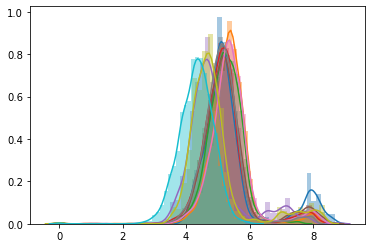

In [118]:
for i in range(av_batch_expr.shape[0]):
    batch_name = av_batch_expr.index[i]
    values = batch_adata[:,batch_adata.var['batch'] == batch_name]
    values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])]
    sns.distplot(values_use.X)

In [24]:
batch_adata.obs['batch_cluster'] = clusters

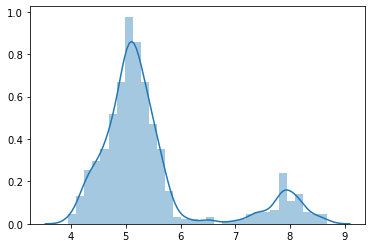

In [105]:
i=0
batch_name = av_batch_expr.index[i]
values = batch_adata[:,batch_adata.var['batch'] == batch_name]
values_use = values[values.obs['batch_cluster'] == np.argmin(av_batch_expr.loc[batch_name,:])]
sns.distplot(values_use.X)

In [31]:
batch_adata.var

,batch
0,barcode1
1,barcode2
2,barcode3
3,barcode4
4,barcode5
5,barcode6
6,barcode7
7,barcode8
8,barcode9
9,barcode10


In [30]:
batch_adata.n_obs

35371

In [31]:
sum(n_positive == 0).tolist()[0][0]

0

In [32]:
# assign cells to HTO and get expression values of each
best = [drop_identifier(a=batch_adata.X[x, :],
                        n_top=int(n_positive[x]),
                        bc_ids=batch_adata.var['batch'])
        for x in range(batch_adata.n_obs)]


In [33]:
best_guess = [x['barcodes'] for x in best]
best_exp = [x['expression'] for x in best]

batch_adata.obs['best_guess'] = best_guess
batch_adata.obs['expression'] = best_exp

In [34]:
# Assemble some meta data
n_cells_atLevel = [sum(n_positive == i).tolist()[0][0] for i in range(0,7)]
n_cells_atLevel_df = pd.DataFrame({"cells_per_drop": ["{} cells per drop".format(x) for x in range(0,7)],
                                   "N_drops": n_cells_atLevel})


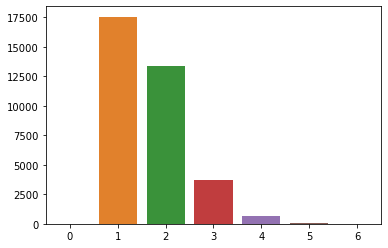

In [36]:
lol = sns.barplot(x=list(range(0,7)), y=n_cells_atLevel)

In [127]:
plt.show(lol)

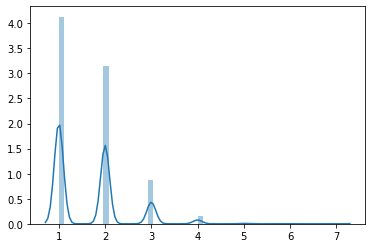

In [37]:
sns.distplot(n_positive)

In [109]:
[sum(n_positive > i).tolist()[0][0] for i in range(0,7)]

[35371, 17471, 4276, 566, 43, 3, 0]

In [98]:
type(adata.X[:,0])

scipy.sparse.csr.csr_matrix

In [99]:
batch_adata.X[:,0]

<35371x1 sparse matrix of type '<class 'numpy.float32'>'
	with 35367 stored elements in Compressed Sparse Row format>

In [100]:
best = [drop_identifier(a=batch_adata.X[x,:],
                              n_top=int(n_positive[x]),
                              bc_ids=batch_adata.var['batch'])
              for x in range(batch_adata.n_obs)]

In [101]:
best_guess = [x['barcodes'] for x in best]
best_exp = [x['expression'] for x in best]

In [102]:
batch_adata.obs['best_guess'] = best_guess
batch_adata.obs['expression'] = best_exp

In [103]:
batch_adata.obs

,n_counts,batch_cluster,assignment,best_guess,expression
AAACCCAAGAAGTCTA-1,3470.0,8,MTP,"(barcode3, barcode2)","(8.64, 8.16)"
AAACCCAAGAGGTCGT-1,2601.0,0,MTP,"(barcode6, barcode9, barcode4)","(8.46, 7.72, 7.69)"
AAACCCAAGCATCCTA-1,905.0,0,MTP,"(barcode6, barcode3)","(8.82, 6.53)"
AAACCCAAGCATTGAA-1,1256.0,5,SNG,"(barcode10,)","(8.85,)"
AAACCCAAGGAAGTGA-1,1587.0,7,MTP,"(barcode5, barcode6)","(8.39, 7.93)"
...,...,...,...,...,...
TTTGTTGTCCATTTGT-1,727.0,7,SNG,"(barcode5,)","(8.67,)"
TTTGTTGTCCCAACTC-1,1541.0,6,SNG,"(barcode7,)","(8.87,)"
TTTGTTGTCCGAGGCT-1,1611.0,6,MTP,"(barcode1, barcode7)","(8.5, 8.21)"
TTTGTTGTCGTTCGCT-1,1016.0,2,SNG,"(barcode1,)","(8.96,)"


In [398]:
a = batch_adata.X[0,:].toarray()[0].tolist()
bc_ids = batch_adata.var['batch'].tolist()

In [408]:
a_ord, bc_ids_ord = zip(*sorted(zip(a, bc_ids), reverse=True))

In [413]:
a_ord[:2]

(8.63879680633545, 8.157093048095703)

In [381]:
batch_adata.var['batch'].tolist()

['barcode1',
 'barcode2',
 'barcode3',
 'barcode4',
 'barcode5',
 'barcode6',
 'barcode7',
 'barcode8',
 'barcode9',
 'barcode10']